In [82]:
### Skin Cancer Classification Project
### Dataset Used: HAM10000

In [83]:
!pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [84]:
## Import Libraries
# !pip install tensorflow
!pip install pandas
# !pip install numpy==1.23

import pandas as pd
import numpy as np
import csv
import string
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [85]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [86]:
# Calculate norm mean and norm std
# norm_mean,norm_std = compute_img_mean_std(all_image_path)

# Manually adding
norm_mean = [0.7630366, 0.5456423, 0.5700427]
norm_std = [0.14092803, 0.15261365, 0.16997027]

In [87]:
## Data Preprocessing

# Data Folder Inspection
path = 'dataset_HAM10000'
# List files in the folder
file_list = os.listdir(path)
print(file_list)

['HAM10000_images', 'HAM10000_metadata.csv', 'HAM10000_metadata_fitzpatrick.csv']


In [88]:
# Create a new directory

# Read csv file
df = pd.read_csv('dataset_HAM10000/HAM10000_metadata_fitzpatrick.csv')

# Display dataframe
display(df)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath,fitzpatrick
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1


In [89]:
# Label encoding for y
# {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 6, 'nv': 4, 'vasc': 5}

# # Create a LabelEncoder object
# label_encoder = LabelEncoder()

# Define mapping
label_mapping = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'nv': 4, 'vasc': 5, 'mel': 6}

# Encode the 'dx' column using the provided mapping
df['dx_encoded'] = df['dx'].map(label_mapping)

# # Display the mapping between original class labels and their encoded values
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print(label_mapping)

In [90]:
display(df)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath,fitzpatrick,dx_encoded
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0


In [91]:
# Get unique cell_type to cell_type_idx
dxs = list(df.dx.unique())

print(dxs)

for dx in dxs:
    print(dx, df_model[df_model['dx'] == dx]['dx_encoded'].unique())

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']
bkl [2]
nv [4]
df [3]
mel [6]
vasc [5]
bcc [1]
akiec [0]


In [92]:
# Duplicate processing

# Count the frequency of each lesion_id
lesion_counts = df['lesion_id'].value_counts()

# Filter lesion_id with freq > 1
lesion_with_duplicates = lesion_counts[lesion_counts>1]

# Filter lesion_id with freq = 1
lesion_without_duplicates = lesion_counts[lesion_counts==1]

print(lesion_without_duplicates)

lesion_id
HAM_0001396    1
HAM_0006071    1
HAM_0002551    1
HAM_0000832    1
HAM_0000918    1
              ..
HAM_0007303    1
HAM_0007308    1
HAM_0007622    1
HAM_0002954    1
HAM_0006592    1
Name: count, Length: 5514, dtype: int64


In [93]:
# Filter the original dataframe based on lesion_without_duplicates indices
unique_lesions_df = df[df['lesion_id'].isin(lesion_without_duplicates.index)]

# Filter the original dataframe based on lesion_with_duplicates indices
duplicate_lesions_df = df[df['lesion_id'].isin(lesion_with_duplicates.index)]

# Display the new dataframe
display(unique_lesions_df)

display(duplicate_lesions_df)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath,fitzpatrick,dx_encoded
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,2,2
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6,2
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,rosendahl,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
...,...,...,...,...,...,...,...,...,...,...,...
9988,HAM_0001036,ISIC_0027588,akiec,histo,50.0,female,face,rosendahl,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
9990,HAM_0004462,ISIC_0027334,akiec,histo,45.0,male,trunk,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
9991,HAM_0001152,ISIC_0030133,akiec,histo,65.0,male,face,rosendahl,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,rosendahl,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath,fitzpatrick,dx_encoded
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,0


In [94]:
random_state = 101
train_data, test_data = train_test_split(unique_lesions_df, train_size=0.8, random_state=random_state)

In [95]:
test_data.shape

(1103, 11)

In [96]:
train_data.shape

(4411, 11)

In [97]:
train_data = pd.concat([train_data, duplicate_lesions_df], ignore_index=True)
train_data.shape

(8912, 11)

In [98]:
# Visualize 
train_data.fitzpatrick.value_counts()

fitzpatrick
1    6276
6    1841
2     484
3     189
4      78
5      44
Name: count, dtype: int64

In [99]:
test_data.fitzpatrick.value_counts()

fitzpatrick
1    876
2     88
6     76
3     43
4     14
5      6
Name: count, dtype: int64

In [100]:
train_data.dx.value_counts() # Almost same 

dx
nv       5820
mel      1062
bkl      1015
bcc       475
akiec     298
vasc      133
df        109
Name: count, dtype: int64

In [101]:
# This fixes augmentation rate for the dx_encoded or dx (diseases)
# label_mapping = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'nv': 4, 'vasc': 5, 'mel': 6}
# weights are for corresponding positions in label_mapping

data_aug_rate = [15,10,5,50,0,40,5]

for i in range(7):
    if data_aug_rate[i]:
        # Modify how data is selected and replicated
        temp_df = train_data.loc[train_data['dx_encoded'] == i, :].copy()  # Create a copy to avoid modifying original

        temp_df = pd.concat([temp_df]*(data_aug_rate[i]-1), ignore_index=True)
        train_data = pd.concat([train_data, temp_df], ignore_index=True)

train_data['dx'].value_counts()

dx
nv       5820
df       5450
vasc     5320
mel      5310
bkl      5075
bcc      4750
akiec    4470
Name: count, dtype: int64

In [102]:
def custom_preprocessing_function(image):
    image = image/255.0
    image = (image-norm_mean)/norm_std
    return image

In [103]:
# ImageDataGenerator


# Data Augmentation and Normalization for Training
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_function,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Data Normalization for Validation/Test
test_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing_function,
    # rescale=1./255
)

In [104]:
display(train_data.head())

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath,fitzpatrick,dx_encoded
0,HAM_0006058,ISIC_0028911,nv,follow_up,40.0,female,trunk,vidir_molemax,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,4
1,HAM_0006060,ISIC_0030513,nv,follow_up,50.0,female,lower extremity,vidir_molemax,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6,4
2,HAM_0002433,ISIC_0032011,nv,follow_up,45.0,female,upper extremity,vidir_molemax,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,3,4
3,HAM_0000202,ISIC_0027219,bkl,histo,50.0,male,face,rosendahl,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,4,2
4,HAM_0005473,ISIC_0026050,nv,follow_up,50.0,male,back,vidir_molemax,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,4


In [105]:
# Add .jpg at the end
# Assuming `train_data` and `test_data` are your dataframes
train_data['image_id'] = train_data['image_id'].apply(lambda x: x + '.jpg')
test_data['image_id'] = test_data['image_id'].apply(lambda x: x + '.jpg')


In [106]:
display(train_data.head())

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,filepath,fitzpatrick,dx_encoded
0,HAM_0006058,ISIC_0028911.jpg,nv,follow_up,40.0,female,trunk,vidir_molemax,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,4
1,HAM_0006060,ISIC_0030513.jpg,nv,follow_up,50.0,female,lower extremity,vidir_molemax,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,6,4
2,HAM_0002433,ISIC_0032011.jpg,nv,follow_up,45.0,female,upper extremity,vidir_molemax,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,3,4
3,HAM_0000202,ISIC_0027219.jpg,bkl,histo,50.0,male,face,rosendahl,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,4,2
4,HAM_0005473,ISIC_0026050.jpg,nv,follow_up,50.0,male,back,vidir_molemax,/content/gdrive/MyDrive/dataset_HAM10000/HAM10...,1,4


In [107]:
# Input size for resizing
input_size = 224  # Specify your desired input size
data_path = 'dataset_HAM10000/HAM10000_images'

# Flow data from directories using data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=data_path,
    x_col="image_id",
    y_col="dx_encoded",
    target_size=(input_size, input_size),
    batch_size=64,
    class_mode="raw",
    seed=random_state
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=data_path,
    x_col="image_id",
    y_col="dx_encoded",
    target_size=(input_size, input_size),
    batch_size=64,
    class_mode="raw",
    seed=random_state
)

Found 36195 validated image filenames.
Found 1103 validated image filenames.


In [108]:
# Model

from tensorflow.keras.applications import DenseNet121

# Initialize base model
# Set input shape, remove dense layers
pre_trained_model = DenseNet121(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet'
)

# Freeze the weights of the layers
# for layer in pre_trained_model.layers:
#   layer.trainable = False

In [ ]:
# Pre-trained model summary
pre_trained_model.summary()

In [109]:
# Last layer of our base = ''
print(pre_trained_model.output_shape)

# Last output from pre-trained model
last_output = pre_trained_model.output

(None, 7, 7, 1024)


In [112]:
from tensorflow.keras import Model
from tensorflow.keras import layers

# Add FC/Dense Layers at the top

# Flatten to 1 dim
x = layers.Flatten()(last_output)

# FC layer with 512 hidden units and ReLU
x = layers.Dense(512, activation='relu')(x)

# Final prediction layer
x = layers.Dense(7, activation='sigmoid')(x)

# Append the dense new trainable layer to base model from transfer learning
model = Model(pre_trained_model.input, (x))

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 32,731,719 (124.86 MB)

 Trainable params: 32,648,071 (124.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [142]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# Define the ModelCheckpoint callback to save only the best model weights
checkpoint = ModelCheckpoint(
    'best_model.weights.h5',        # Filepath to save the best model weights
    monitor='val_accuracy',         # Metric to monitor (e.g., validation accuracy)
    save_weights_only=True,         # Save only the model's weights
    save_best_only=True,            # Save only the best model
    mode='max',                     # Mode of monitoring ('max' for accuracy, 'min' for loss)
    verbose=1                       # Verbosity mode
)

csv_logger = CSVLogger('training.log')     # Logs training metrics to a CSV file

In [141]:
# Compile model
from tensorflow.keras.optimizers import Adam

# Instantiate the Adam optimizer with a learning rate of 0.01
adam_optimizer = Adam(learning_rate=0.001)

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = adam_optimizer,
    metrics = ['accuracy']
)

In [118]:
from datetime import datetime

# Get the current time
start_time = datetime.now()

# Print the current time
print("Start time:", start_time)


Start time: 2024-07-05 14:04:52.605959


In [119]:
# Train model
history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = test_generator,
    verbose = 1,
    callbacks = [checkpoint, csv_logger]
)

Epoch 1/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 375s 654ms/step - accuracy: 0.7201 - loss: 0.7400 - val_accuracy: 0.0326 - val_loss: 4152.1870
Epoch 2/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 370s 646ms/step - accuracy: 0.7304 - loss: 0.7237 - val_accuracy: 0.8033 - val_loss: 0.6051
Epoch 3/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 371s 649ms/step - accuracy: 0.8080 - loss: 0.5141 - val_accuracy: 0.7996 - val_loss: 0.6664
Epoch 4/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 366s 639ms/step - accuracy: 0.8351 - loss: 0.4276 - val_accuracy: 0.0209 - val_loss: 2.2989
Epoch 5/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 372s 648ms/step - accuracy: 0.7982 - loss: 0.5272 - val_accuracy: 0.8196 - val_loss: 0.5793
Epoch 6/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 369s 644ms/step - accuracy: 0.8456 - loss: 0.3808 - val_accuracy: 0.5558 - val_loss: 2.7709
Epoch 7/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 369s 643ms/step - accuracy: 0.8525 - loss: 0.3787 - val_accuracy: 0.8486 - val_loss: 0.5789
Epoch 8/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 375s 655ms/step - accuracy: 0.860

In [120]:
from datetime import datetime

# Get the current time
end_time = datetime.now()

# Print the current time
print("End time:", end_time)


End time: 2024-07-05 19:52:08.821106


In [121]:
total_time = end_time - start_time
print("Total time:", total_time)

Total time: 5:47:16.215147


In [128]:
# Save the entire model to a HDF5 file
model.save('Skin_lesion_classification_tf_Densenet121_05072024.h5')

In [129]:
# Save the weights
model.save_weights('Skin_lesion_classification_tf_Densenet121_05072024.weights.h5')

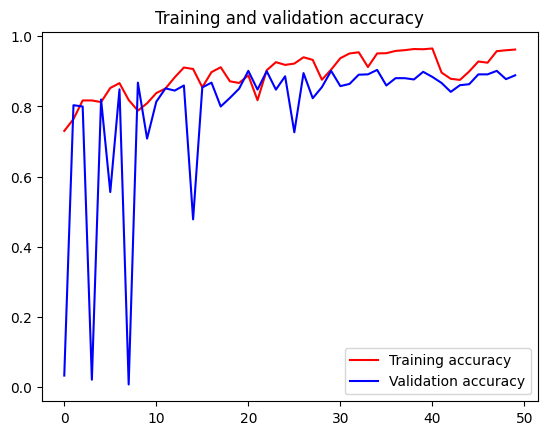

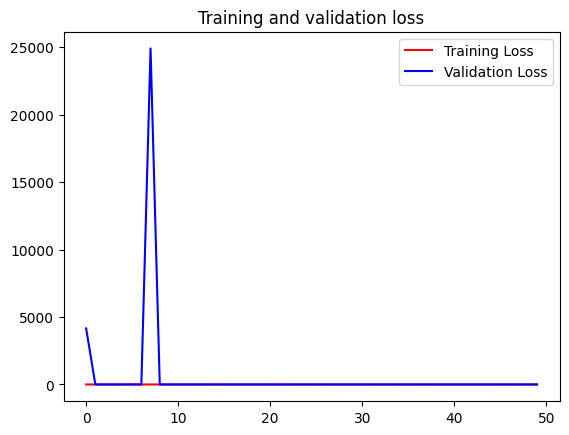

In [130]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [131]:
# Get the true labels from the test generator
test_labels = test_generator.labels

In [134]:
# Predict on the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 545ms/step


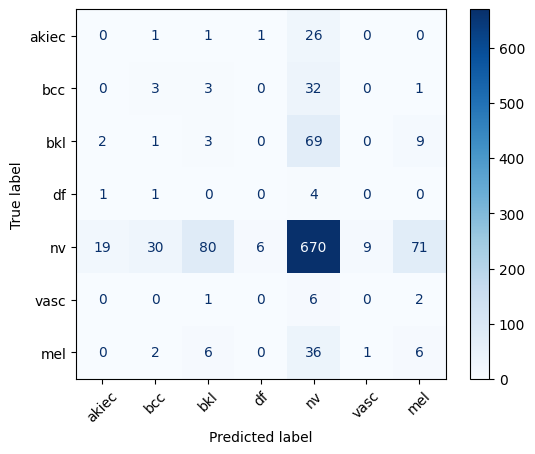

In [138]:
def generate_confusion_matrix(test_labels, predicted_labels):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Generate the confusion matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    
    # Map the numeric labels back to their string labels
    label_mapping = {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'nv', 5: 'vasc', 6: 'mel'}
    labels = [label_mapping[i] for i in range(len(label_mapping))]
    
    # Display the confusion matrix with labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.show()

generate_confusion_matrix(test_labels, predicted_labels)